In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('va_filtered_listings_albemarle.csv')

df.head()

,period_begin,period_end,period_duration,region_type,region_type_id,table_id,is_seasonally_adjusted,region,city_x,state,...,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,parent_metro_region,parent_metro_region_metro_code,last_updated,zipcode,city_y,county
0,6/1/2022,8/31/2022,90,zip code,2,9054,f,Zip Code: 22932,NaN,Virginia,...,NaN,0.650000,-0.115957,0.650000,"Charlottesville, VA",16820,2/10/2025 14:21,22932,Yancey mills,Albemarle
1,6/1/2019,8/31/2019,90,zip code,2,9048,f,Zip Code: 22911,NaN,Virginia,...,NaN,0.012987,0.007369,0.006364,"Charlottesville, VA",16820,2/10/2025 14:21,22911,Zcta 22911,Albemarle
2,10/1/2024,12/31/2024,90,zip code,2,9054,f,Zip Code: 22932,NaN,Virginia,...,NaN,0.310345,0.000000,-0.097063,"Charlottesville, VA",16820,2/10/2025 14:21,22932,Yancey mills,Albemarle
3,3/1/2020,5/31/2020,90,zip code,2,9065,f,Zip Code: 22947,NaN,Virginia,...,NaN,0.000000,0.000000,0.000000,"Charlottesville, VA",16820,2/10/2025 14:21,22947,Boyd tavern,Albemarle
4,2/1/2018,4/30/2018,90,zip code,2,9841,f,Zip Code: 24590,NaN,Virginia,...,NaN,NaN,NaN,NaN,"Charlottesville, VA",16820,2/10/2025 14:21,24590,Scottsville,Albemarle


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4428 entries, 0 to 4427
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   period_begin                    4428 non-null   object 
 1   period_end                      4428 non-null   object 
 2   period_duration                 4428 non-null   int64  
 3   region_type                     4428 non-null   object 
 4   region_type_id                  4428 non-null   int64  
 5   table_id                        4428 non-null   int64  
 6   is_seasonally_adjusted          4428 non-null   object 
 7   region                          4428 non-null   object 
 8   city_x                          0 non-null      float64
 9   state                           4428 non-null   object 
 10  state_code                      4428 non-null   object 
 11  property_type                   4428 non-null   object 
 12  property_type_id                44

In [4]:
df['period_begin'] = pd.to_datetime(df['period_begin'])
df.set_index('period_begin', inplace=True)

In [5]:
monthly_data = df.copy().resample('M').mean()
monthly_data['median_sale_price'].fillna(method='ffill', inplace=True)

In [6]:
train_size = int(len(monthly_data) * 0.8)
train = monthly_data[:train_size]
test = monthly_data[train_size:]

### Fitting the model

In [7]:
from math import sqrt

In [8]:
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12  # s=12 for monthly data

# Fit SARIMA model
model = SARIMAX(train['median_sale_price'], 
                order=(p, d, q), 
                seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=False)

forecast = model_fit.forecast(steps=len(test))

### Training sarima

In [9]:
rmse = sqrt(mean_squared_error(test['median_sale_price'], forecast))
print(f"SARIMA Model RMSE: {rmse:.2f}")

SARIMA Model RMSE: 156971.61


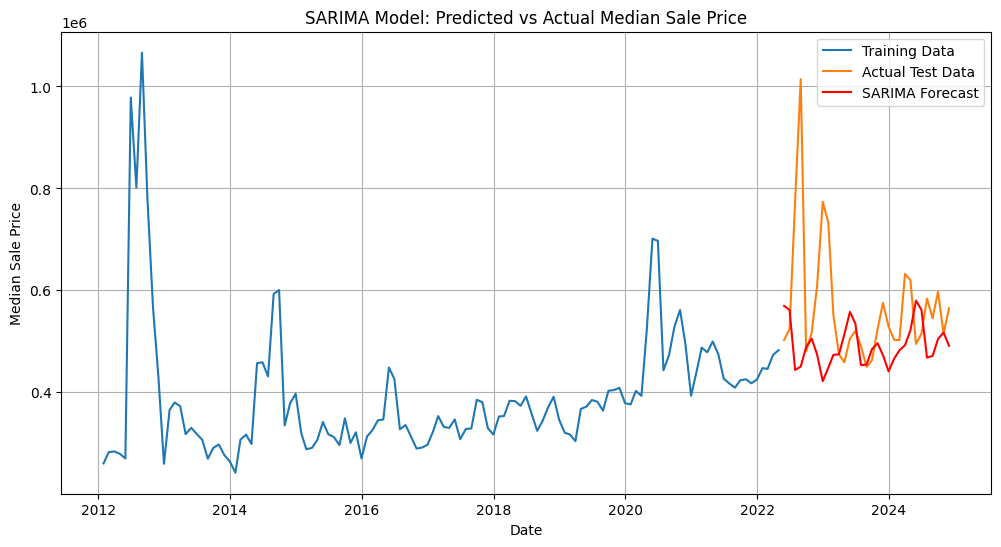

In [10]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['median_sale_price'], label='Training Data')
plt.plot(test.index, test['median_sale_price'], label='Actual Test Data')
plt.plot(test.index, forecast, label='SARIMA Forecast', color='red')
plt.title('SARIMA Model: Predicted vs Actual Median Sale Price')
plt.xlabel('Date')
plt.ylabel('Median Sale Price')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
exog_columns = ['median_list_price', 'median_ppsf', 'homes_sold', 'inventory', 'median_dom']

# Prepare exogenous variables for training and testing
exog_train = train[exog_columns].fillna(method='ffill')
exog_test = test[exog_columns].fillna(method='ffill')

In [12]:
# Fit SARIMAX model
model_exog = SARIMAX(train['median_sale_price'], 
                     exog=exog_train,
                     order=(p, d, q), 
                     seasonal_order=(P, D, Q, s))
model_exog_fit = model_exog.fit(disp=False)

forecast_exog = model_exog_fit.forecast(steps=len(test), exog=exog_test)

SARIMAX Model with Exogenous Variables RMSE: 104117.97


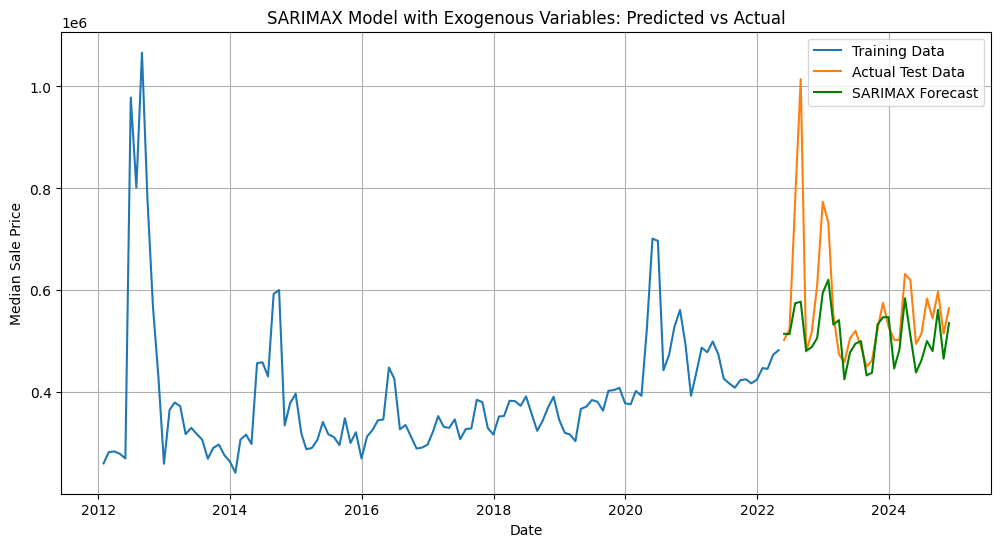

In [13]:
rmse_exog = sqrt(mean_squared_error(test['median_sale_price'], forecast_exog))
print(f"SARIMAX Model with Exogenous Variables RMSE: {rmse_exog:.2f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['median_sale_price'], label='Training Data')
plt.plot(test.index, test['median_sale_price'], label='Actual Test Data')
plt.plot(test.index, forecast_exog, label='SARIMAX Forecast', color='green')
plt.title('SARIMAX Model with Exogenous Variables: Predicted vs Actual')
plt.xlabel('Date')
plt.ylabel('Median Sale Price')
plt.legend()
plt.grid(True)
plt.show()